# Exploring locations to open an Italian restaurant in London
### Applied Data Science Capstone project by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
  * [Feature selection](#feature_selection)
  * [Data sources](#data_sources)
  * [Data acquisition and cleaning](#data_acquisition_and_cleaning)
      * [London business districts](#london_business_districts)
      * [Metro stations in the area](#metro_stations)
      * [Food venues near the stations](#food_venues)
* [Methodology](#methodology)
* [Analysis](#analysis)
  * [Distrubution of food venues per area](#food_distribution)
  * [Potential candidates](#potential_candidates)
  * [Choosing the final candidate](#final_candidate)
  * [Reverse geocoding](#reverse_geocoding)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction  <a name="introduction"></a>

### Background

London is the capital and largest city of England and the third-most populous city in Europe. It is considered to be one of the world's most visited, most expensive and most influential cities. It is known for its rainy climate, ethnic diversity, Big Ben, the financial industry, and its sprawling subway system.

London is also one of the most amazing places to eat, thanks to an incredible variety of international cuisines and some of the most talented chefs in the world. London’s thriving economy, multicultural demographics and access to ingredients make it an ideal place for restaurants to flourish.

### Business problem

The objective of this project is to find the most suitable location(s) to open a new Italian restaurant in London.

### Target audience

Types of clients or a group of people that would be interested in this project are:
* Business personnel who wants to invest or open an Italian restaurant in London. This analysis will be a comprehensive guide to start or expand restaurants targeting the large pool of office workers in major business districts of London city during lunch hours. 



## Data  <a name="data"></a>

### Feature selection  <a name="feature_selection"></a>

Based on definition of our problem, factors that will influence our decision are:
*	 Restaurant business needs a regular flow of customers daily, so we will look for a places with at least a few business centers and offices nearby.
*	 It is good for businesses to have as few rivals as possible, so we will be looking for places with the lowest number of existing restaurants (any type of restaurant) and specifically the Italian restaurants in the vicinity.
*	Good transportation system/connection to other neighborhoods of the city. So we will search for places with at least one metro station situated within walking distance.

We decided to look for potential places in the major business districts of London city. It should be within a walking distance to nearby metro stations, so we will restrict ourselves to areas within 500 meters from every metro station. Next, we will gather locations of already existing restaurants nearby. The most prominent candidate area will be chosen based on the food venue density and proximity to the center of the business district. Potential places for a new Italian restaurant within the chosen area will be selected based on these criteria: not closer to other Italian restaurants within 200 meters and other food venues within 100 meters.

### Data sources  <a name="data_sources"></a>

The following data sources will be needed to extract/generate the required information:
*    [Reaserch article on major business districts in London.](https://www.savills.co.uk/research_articles/229130/177600-0)
*    Locations of metro stations and different cuisine restaurants will be gathered with the help of [Foursquare API.](https://developer.foursquare.com/docs)
*	 Reverse geocoding (coordinates transformation to address)  using [LocationIQ API.](https://locationiq.com/docs?)

In [1]:
#Importing libraries
import folium
from folium.plugins import HeatMap
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import IFrame
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import requests
import time

### Data acquisition and cleaning  <a name="data_acquisition_and_cleaning"></a>


#### London business districts <a name="london_business_districts"></a>

First of all, we need to find the major business districts in London. There are five districts defined in our [source data](https://www.savills.co.uk/research_articles/229130/177600-0), but we will consider only the biggest ones: **West End**, __The City__, and **Canary Wharf**. 

<figure class="image">
  <img src="http://research.euro.savills.co.uk/_images/map-new(1).jpg" alt="Five major business districts in London" width="700">
  <figcaption style='text-align: center'>Fig 1. Five major business districts in London.</figcaption>
</figure>

Next, we need to find the coordinates of these districts. As we can see, all three are situated close to each other, so we can approximately draw a rectangular boundary around them. To do that, we will use [google maps website](https://www.google.com/maps) to get the boundary coordinates manually. 

In [2]:
IFrame('https://www.google.com/maps/d/u/0/embed?mid=1C9_LVA2I7HgjZMLBwxlyFHn5GUU6f6BN'\
               , width=650, height=450)

In [3]:
# As we can see from the google maps IFrame above, the coordinates of the border points are:
sw = [51.461,-0.236]
nw = [51.542,-0.236]
ne = [51.542,0.001]
se = [51.461,0.001]

center_lat = (ne[0] + sw[0])/2 
center_lon = (ne[1] + sw[1])/2 

For visual reference, lets also use an interactive drawing tool provided by [geojson.io](http://geojson.io/) and create approximate maps for our districts.

In [4]:
# after drawing the maps and storing them in a github repository,
# lets download the JSON files

url = r'https://raw.githubusercontent.com/pavelg0t/Coursera_Capstone/master/Business%20districts/business_districts.json'

districts = requests.get(url).json()

In [5]:
# and visualise the maps using folium library

def district_style(feature):
    return { 'color': 'blue', 'fill': True }

map_districts = folium.Map(location=[center_lat, center_lon], zoom_start=12, control_scale = True)

folium.GeoJson(districts, style_function=district_style, name='geojson').add_to(map_districts)

map_districts

#### Finding metro stations in the area   <a name="metro_stations"></a>

Now, we can proceed to the next task of finding the coordinates of all the metro stations in the chosen rectangle area. To do that, we will use the **Foursquare API**. By doing a little searching on the **Foursquare API** developer’s [documentations website](https://developer.foursquare.com/docs/resources/categories), one can notice that all the venues are divided into 10 different categories, each having its own subcategories. Their catogory names and ids are as listed below:

| Name                        |               Id             | 
| :----:                      |             :----:           |
| Arts & Entertainment        | 4d4b7104d754a06370d81259     |
| College & University        | 4d4b7105d754a06372d81259     |
| Event                       | 4d4b7105d754a06373d81259     |
| Food                        | 4d4b7105d754a06374d81259     |
| Nightlife Spot              | 4d4b7105d754a06376d81259     |
| Outdoors & Recreation       | 4d4b7105d754a06377d81259     |
| Professional & Other Places | 4d4b7105d754a06375d81259     |
| Residence                   | 4e67e38e036454776db1fb3a     |
| Shop & Service              | 4d4b7105d754a06378d81259     |
| Travel & Transport          | 4d4b7105d754a06379d81259     |

For now, we are only interested in the `Travel & Transport` category. By looking at its [subcategories](https://developer.foursquare.com/docs/resources/categories), we can quickly find the one we are looking for: `Metro Station` with id code `4bf58dd8d48988d1fd931735`.

To obtain the locations of all the metro stations we will use the **Foursquare’s** [Places API](https://developer.foursquare.com/docs/places-api/) that offers real-time access to **Foursquare’s** global database of rich venue data and user content. One needs to create the developer’s account and choose the name for the first Foursquare app. After its done, two unique keys will be assigned: `CLIENT ID` and `CLIENT SECRET`.

In [6]:
#Lets define our Foursquare's Places API credentials

CLIENT_ID = '---' # your Foursquare ID
CLIENT_SECRET = '---' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ---
CLIENT_SECRET:---


There are many API [endpoints](https://developer.foursquare.com/docs/places-api/endpoints/) one can choose, but we will use the regular [search](https://developer.foursquare.com/docs/api-reference/venues/search/) endpoint. A simple code example executing an API call is shown below:

```python
import requests
url = 'https://api.foursquare.com/v2/venues/search?'\
    + 'client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    VERSION,
    51.555, #laitude
    -0.155, #longitude
    500     # radius in meters
    )
resp = requests.get(url).json()
```

The API call above returns information about any venue within radius of `500` meters from a center point describe by coordinates `(51.555,-0.155)`. Resulting data is stored as a `.json` format variable `resp`.

There are lots of different [parameters](https://developer.foursquare.com/docs/api-reference/venues/search/#parameters) one can add to url query to narrow down the resulting data. We will specify the `categoryId` of the venues located in the rectangle are defined by south-west `sw` and north-east `ne` points. We also need to specify the `limit` parameter defining the number of venues returned (**max is 50**). Because our defined rectangular area can cover more than 50 metro stations, we will divide it into grid of smaller rectangulars as follows.

In [8]:
# define a function that creates a grid

def make_grid(sw,ne,N):
    """
    Area defined by sw and ne points is divided into num*num identical rectangles.
    
    Input:
        sw: south-west corner point (lat,lon)
        ne: north-east corner point (lat,lon)
        N: number of rectangles in one row/column
    
    Output:   
        coordinates of N*N smaller rectangles (their sw, ne and center points)
    """
    
    lat_step = abs(ne[0] - sw[0])/N  
    lon_step = abs(ne[1] - sw[1])/N 
    
    lat_middle = (ne[0] + sw[0])/2 
    lon_middle = (ne[1] + sw[1])/2 

    lat_vec = (np.arange(N, -1, -1)-N/2)*lat_step
    lon_vec = (np.arange(0, N+1, 1)-N/2)*lon_step

    lon_grid, lat_grid = np.meshgrid(lon_vec, lat_vec, sparse=False)
    lat_grid += lat_middle
    lon_grid += lon_middle 
    
    lat_grid = np.around( lat_grid, decimals=4)
    lon_grid = np.around( lon_grid, decimals=4)
    
    #find coordinates of the south-west and north-west corners for each square in the grid
    sw_lon = lon_grid[1:,:-1]
    sw_lat = lat_grid[1:,:-1]
    sw = [ (sw_lat.flatten()[idx],sw_lon.flatten()[idx]) for idx in range(N*N)]
    
    ne_lon=lon_grid[:-1,1:]
    ne_lat=lat_grid[:-1,1:]
    ne = [ (ne_lat.flatten()[idx],ne_lon.flatten()[idx]) for idx in range(N*N)]
    
    center_lon = np.around( sw_lon + lon_step/2, decimals=4)
    center_lat = np.around( sw_lat + lat_step/2, decimals=4)
    center = [ (center_lat.flatten()[idx],center_lon.flatten()[idx]) for idx in range(N*N)]
      
    return sw, ne, center

In [9]:
# create the grid and store it as a pandas DataFrame object

N = 3
sw_3x3, ne_3x3, center_3x3 = make_grid(sw,ne,N)

grid_3x3 = pd.DataFrame({'no':np.arange(N*N).tolist(),'sw':sw_3x3,'ne':ne_3x3})
grid_3x3.head()

,no,sw,ne
0,0,"(51.515, -0.236)","(51.542, -0.157)"
1,1,"(51.515, -0.157)","(51.542, -0.078)"
2,2,"(51.515, -0.078)","(51.542, 0.001)"
3,3,"(51.488, -0.236)","(51.515, -0.157)"
4,4,"(51.488, -0.157)","(51.515, -0.078)"


In [10]:
# visualize the grid using Folium library

#create map
map_grid = folium.Map(location=[center_lat, center_lon], zoom_start=12,tiles='Stamen Terrain', control_scale = True)

for idx, area in grid_3x3.iterrows():
    map_grid.add_child( folium.Rectangle(bounds=[area['sw'],area['ne']], \
             color='orange',opacity=1,weight=4, popup=str(idx)))
    
folium.GeoJson(districts, style_function=district_style, name='geojson').add_to(map_grid)
    
folium.Marker(
    location=[sw[0], sw[1]],
    popup='South-west point',
    icon=folium.Icon(color='green')
).add_to(map_grid)

folium.Marker(
    location=[ne[0],ne[1]],
    popup='North-east point',
    icon=folium.Icon(color='red')
).add_to(map_grid)
    
map_grid


**Finally** we can make our first API call! We will store resulting data into the pandas.DataFrame object `metro_stations`.

In [11]:
metro_stations = pd.DataFrame(columns=['name','latitude','longitude'])

for idx, area in grid_3x3.iterrows():
    print(idx,end=' ')
    url = 'https://api.foursquare.com/v2/venues/search?'\
        + 'client_id={}&client_secret={}&v={}&sw={},{}&ne={},{}&limit={}&categoryId={}&intent=browse'.format(
        CLIENT_ID, 
        CLIENT_SECRET,
        VERSION,
        area['sw'][0],
        area['sw'][1],
        area['ne'][0],
        area['ne'][1],
        50,
        '4bf58dd8d48988d1fd931735'
        )
    try:
        stations = requests.get(url).json()["response"]['venues']

        for station in stations:
            index = metro_stations.shape[0]
            metro_stations.loc[index] = [station['name'], station['location']['lat'], station['location']['lng']]
    except:
        print('e',end=' ')
        #if there is no venues returned, Nan value will be filled in.

0 1 2 3 4 5 6 7 8 

Lets inspect our data set:

In [12]:
metro_stations.tail()

,name,latitude,longitude
110,Stockwell London Underground Station,51.472292,-0.122827
111,Clapham North London Underground Station,51.465023,-0.129516
112,Battersea Power Station London Underground Sta...,51.479946,-0.142032
113,Nine Elms London Underground Station,51.480260,-0.129323
114,Nelson's row Station,51.462041,-0.137580


We can see that there are also rows that represent other than underground stations. We will select only those that have 'underground' in their name. 

In [13]:
idx = [ 'underground' in name.lower() for name in metro_stations['name'].values.tolist() ]
metro_stations = metro_stations[idx].reset_index(drop=True)
metro_stations.tail()

,name,latitude,longitude
101,Clapham Common London Underground Station,51.461736,-0.138245
102,Stockwell London Underground Station,51.472292,-0.122827
103,Clapham North London Underground Station,51.465023,-0.129516
104,Battersea Power Station London Underground Sta...,51.479946,-0.142032
105,Nine Elms London Underground Station,51.480260,-0.129323


Furthermore, there could be stations very close to each other. To find out, we will need to determine the distances in meters using geographical coordinates of the stations.

We will use the [approximate relations](https://en.wikipedia.org/wiki/Latitude#Length_of_a_degree_of_latitude) below:

    Latitude: 1 deg = 110.574 km
    Longitude: 1 deg = 111.320*cos(latitude 3.1514 /180) km


In [14]:
#calculate euclidean distances
def distance_2D(mat1,mat2,data_type):
    """
    Calculates euclidean distances between points.
    
    Limitations: longitudes of the points no more than +- 0.5 deg apart
                  or no more than ~100 km between them
    
    Input:
        mat1 : Nx2 numpy.ndarray matrix.
        mat2 : Mx2 numpy.ndarray matrix.
        
    Parameters:
        data_type: {'lat_lon', 'x_y'} default 'x_y'.
            if 'lat_lon' is chosen, conversion of delta latitide 
                and delta longitude to delta x and delta y is performed
                before calculating the euclidean distances.
            
    Output:
        NxM matrix representing the euclidean distances.
              (rows are points from mat1, cols from mat2).
    
    """
    #convert coordinates dtype to float
    mat1 = mat1.astype(float)
    mat2 = mat2.astype(float)
    
    #calculate difference (deltas) in the first and second parameter
    del1 = np.repeat(mat2[:,0,np.newaxis], mat1.shape[0] ,axis=1).T - mat1[:,0,np.newaxis]
    del2 = np.repeat(mat2[:,1,np.newaxis], mat1.shape[0] ,axis=1).T - mat1[:,1,np.newaxis]
    
    #convert delta lat and delta lon into delta x and delta y 
    if data_type == 'lat_lon':
        
        del_lat = 110574.0 #in meters
        avg_lat = mat1[:,0].mean() #calculate average longitude of the points
        del_lon = 111320.0*np.cos(avg_lat/180*np.pi)
        
        del1 *= del_lat
        del2 *= del_lon
        
    #calculate euclidean distance    
    dist = np.power( np.power(del1,2) + np.power(del2,2) ,0.5)
    
    return dist

In [15]:
metro_coords = metro_stations[['latitude','longitude']].values

#calculate all the distances rounded to 10 meters precission
res = np.around( distance_2D(metro_coords,metro_coords,'lat_lon') , decimals=-1)
#inspect which are less than 400 meters
tmp = res[res < 400]
#and more than 0 meters
np.sort( tmp[tmp >0] )

array([160., 160., 180., 180., 220., 220., 220., 220., 220., 220., 230.,
       230., 240., 240., 240., 240., 280., 280., 320., 320., 340., 340.,
       340., 340., 350., 350., 350., 350., 380., 380.])

As we can see, the least distance between two different stations is 160 meters which is sufficiently far. To conclude, we have found a total of **106** underground metro stations and their locations are visualized below:

In [16]:
map_stations = folium.Map(location=[center_lat, center_lon], zoom_start=13,\
                          tiles='Stamen Terrain', control_scale = True)

for idx, rect in grid_3x3.iterrows():
    map_stations.add_child( folium.Rectangle(bounds=[[rect['sw'][0],rect['sw'][1]],\
                            [rect['ne'][0],rect['ne'][1]]],color='orange',\
                                             fill=False, popup = str(rect['no'])))


for idx, station in metro_stations.iterrows():
    
    folium.Marker(
        location=[station['latitude'], station['longitude']],
        popup=station['name'],
        icon=folium.Icon(color='red')
    ).add_to(map_stations)
    
map_stations

#### Food venues near the stations  <a name="food_venues"></a>

In this section we are looking for any food venue (including 'Italian restaurant') in the radius of 500 meters from any local metro station, so venues under the parent-category name 'Food' and categoryId '4d4b7105d754a06374d81259' are selected. Furthermore, as we have encoutered a problem with the max. of 50 venues per query, this time we will look for venues in a square grid around every metro station.

Lets create a square 1km x 1km grid around a metro station.

In [17]:
#First, we need to find the sw and ne coordinates of the square
#           so we will write a function that finds them

def find_sw_ne(lat,lon,dr):
    """
    Input:
        lat/lon: coordinates of the center point.
        dr : Length of the border in meters.
    Output:
        sw, ne : coordinates of the south-west and north-east corners.
    """
    
    del_lat = 110574.0 #in meters
    del_lon = 111320.0*np.cos(center_lat/180*np.pi)

    del_r = 500

    ne = [lat + dr/del_lat , lon + dr/del_lon]
    sw = [lat - dr/del_lat , lon - dr/del_lon]
    
    return sw, ne

In [18]:
#Then we create a grid

sw_sq, ne_sq = find_sw_ne(center_lat,center_lon,500)

sw_6x6, ne_6x6, center_6x6 = make_grid(sw_sq,ne_sq,6)

grid_6x6 = pd.DataFrame({'no':np.arange(6*6).tolist(),'sw':sw_6x6,'ne':ne_6x6})
grid_6x6.head()

,no,sw,ne
0,0,"(51.5045, -0.1247)","(51.506, -0.1223)"
1,1,"(51.5045, -0.1223)","(51.506, -0.1199)"
2,2,"(51.5045, -0.1199)","(51.506, -0.1175)"
3,3,"(51.5045, -0.1175)","(51.506, -0.1151)"
4,4,"(51.5045, -0.1151)","(51.506, -0.1127)"


In [19]:
# and Plot the example

map_square = folium.Map(location=[center_lat, center_lon], zoom_start=15, control_scale = True)

for idx, square in grid_6x6.iterrows():
    map_square.add_child( folium.Rectangle(bounds=[[square['sw'][0],square['sw'][1]],\
                            [square['ne'][0],square['ne'][1]]],color='blue',fill_color='blue',\
                                             fill_opacity=0.1, popup = str(rect['no'])))

folium.vector_layers.Circle(
    location=[center_lat, center_lon],
    color ='white',
    opacity=0.8,
    radius = 500, #in meters
).add_to(map_square)
    
map_square

No we are ready to create a square grid for every station and search for any food venue in it.

In [52]:
food_venues = pd.DataFrame(columns=['station_name','venue_name','venue_id','subcategory_name',\
                                            'subcategory_id','latitude','longitude'])


for st_num, station in metro_stations.iterrows():
        
    print(st_num,end=' ')
    
    # get corner coords of the square
    sw_sq, ne_sq = find_sw_ne(station['latitude'],station['longitude'],500)
    # make a 6x6 grid
    sw_grid, ne_grid , center_grid= make_grid(sw_sq,ne_sq,6) 

    # iterate through every box in the grid
    for idx in range(len(sw_grid)):
         
        url = 'https://api.foursquare.com/v2/venues/search?'\
            + 'client_id={}&client_secret={}&v={}&sw={},{}&ne={},{}&limit={}&categoryId={}&intent=browse'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION,
            sw_grid[idx][0],
            sw_grid[idx][1],
            ne_grid[idx][0],
            ne_grid[idx][1],
            50,
            '4d4b7105d754a06374d81259'
            )
        try:
            foods = requests.get(url).json()["response"]['venues']
            
            for food in foods:
                index = food_venues.shape[0]
                food_venues.loc[index]= [station['name'], food['name'], food['id'],\
                                          food['categories'][0]['name'], food['categories'][0]['id'],\
                                          food['location']['lat'], food['location']['lng']]
        except:
            print('e',end=' ')
            #if there is no venues returned, Nan value will be filled in.

       

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 

In [53]:
#Lets inspect the data
food_venues.tail()

,station_name,venue_name,venue_id,subcategory_name,subcategory_id,latitude,longitude
28639,Battersea Power Station London Underground Sta...,Santa Cruz,4f58d7fde4b0c19b5f124292,Deli / Bodega,4bf58dd8d48988d146941735,51.476387,-0.148342
28640,Battersea Power Station London Underground Sta...,Pasta Embassy,5b4874f1febf31002ca3f8b1,Italian Restaurant,4bf58dd8d48988d110941735,51.475409,-0.144421
28641,Battersea Power Station London Underground Sta...,The Bengal Indian Restaurant,5d05f0ff9b0473002c34452d,Indian Restaurant,4bf58dd8d48988d10f941735,51.475830,-0.146097
28642,Battersea Power Station London Underground Sta...,Three Bridges Gastropub,4c63122ae1621b8d03092553,Gastropub,4bf58dd8d48988d155941735,51.476867,-0.146703
28643,Battersea Power Station London Underground Sta...,Sweet Dreams,5aeb0b8265211f002c708141,Ice Cream Shop,4bf58dd8d48988d1c9941735,51.475469,-0.144110


There are 28644 venues in the dataset (could be lot of multiple duplicates).

In [20]:
#food_venues.to_csv('food_venues.csv', index=False)
#food_venues =pd.read_csv('food_venues.csv')

In [21]:
food_venues['subcategory_name'].unique().shape

(246,)

Divided into as many as 246 differnt subcategories.

Lets separete the venues that are categorized as 'italian restaurant' from others.

In [22]:
tmp = food_venues['subcategory_name'] == 'Italian Restaurant'
only_italian = food_venues[tmp].reset_index(drop=True)
only_italian.tail()

,station_name,venue_name,venue_id,subcategory_name,subcategory_id,latitude,longitude
1565,Nine Elms London Underground Station,Tony's Delicatessen,4bab6c85f964a5205ba83ae3,Italian Restaurant,4bf58dd8d48988d110941735,51.482649,-0.123643
1566,Nine Elms London Underground Station,Caminetto,577d626c498ee26c2f05b08c,Italian Restaurant,4bf58dd8d48988d110941735,51.476940,-0.123248
1567,Battersea Power Station London Underground Sta...,Fiume,59c8c4fec4df1d02e4e083eb,Italian Restaurant,4bf58dd8d48988d110941735,51.483218,-0.145840
1568,Battersea Power Station London Underground Sta...,San Gennaro,4b785ce7f964a52089c82ee3,Italian Restaurant,4bf58dd8d48988d110941735,51.476276,-0.148440
1569,Battersea Power Station London Underground Sta...,Pasta Embassy,5b4874f1febf31002ca3f8b1,Italian Restaurant,4bf58dd8d48988d110941735,51.475409,-0.144421


In [23]:
only_italian['venue_id'].unique().shape

(831,)

Out of 1570 records there are **831** unique Italian restaurants in the only_italian dataset (**There are multiple duplicates of same venues due to the overlap of areas around few metro stations, but it is usefull in the later analysis**).

In [25]:
#For visualization puproses lets crate list of unique italian restaurants

unique_only_italian = only_italian.sort_values('venue_id')
unique_only_italian = unique_only_italian.drop_duplicates(subset ='venue_id').reset_index(drop=True)
unique_only_italian.tail()

,station_name,venue_name,venue_id,subcategory_name,subcategory_id,latitude,longitude
826,Camden Town London Underground Station,Cafe Italy,5e28ad7e5aa38d000a96786c,Italian Restaurant,4bf58dd8d48988d110941735,51.538565,-0.144040
827,Old Street London Underground Station,Padella,5e4547254f10a40008fb2240,Italian Restaurant,4bf58dd8d48988d110941735,51.523372,-0.081676
828,Marble Arch London Underground Station,Bocconcino Restaurant,5e502850c0f2c400071aab5f,Italian Restaurant,4bf58dd8d48988d110941735,51.515547,-0.160298
829,Liverpool Street London Underground Station,Sfoglia Bologna,5e5d5676e079c800082a24d2,Italian Restaurant,4bf58dd8d48988d110941735,51.515624,-0.075535
830,Elephant & Castle London Underground Station,Sugo,5e6110f232281c0008d6bf6e,Italian Restaurant,4bf58dd8d48988d110941735,51.493580,-0.098103


In [26]:
food_venues = food_venues[~tmp]
food_venues = food_venues.reset_index(drop=True)
food_venues.tail()

,station_name,venue_name,venue_id,subcategory_name,subcategory_id,latitude,longitude
27124,Battersea Power Station London Underground Sta...,Yummy Chicken Halal,53610d1711d2c3cb01bd7c54,Halal Restaurant,52e81612bcbc57f1066b79ff,51.476362,-0.148003
27125,Battersea Power Station London Underground Sta...,Santa Cruz,4f58d7fde4b0c19b5f124292,Deli / Bodega,4bf58dd8d48988d146941735,51.476387,-0.148342
27126,Battersea Power Station London Underground Sta...,The Bengal Indian Restaurant,5d05f0ff9b0473002c34452d,Indian Restaurant,4bf58dd8d48988d10f941735,51.475830,-0.146097
27127,Battersea Power Station London Underground Sta...,Three Bridges Gastropub,4c63122ae1621b8d03092553,Gastropub,4bf58dd8d48988d155941735,51.476867,-0.146703
27128,Battersea Power Station London Underground Sta...,Sweet Dreams,5aeb0b8265211f002c708141,Ice Cream Shop,4bf58dd8d48988d1c9941735,51.475469,-0.144110


In [27]:
food_venues['venue_id'].unique().size

14253

There are also **14253** other food venues as well.

In [28]:
#For visualization puproses lets crate list of unique italian restaurants

unique_food_venues = food_venues.sort_values('venue_id')
unique_food_venues = unique_food_venues.drop_duplicates(subset ='venue_id').reset_index(drop=True)
unique_food_venues.tail()

,station_name,venue_name,venue_id,subcategory_name,subcategory_id,latitude,longitude
14248,Regent's Park London Underground Station,Laboratorio Pizza,5e7270ecca8b8d0008f3a49c,Pizza Place,4bf58dd8d48988d1ca941735,51.519321,-0.142214
14249,Monument London Underground Station,La Tasca London Leadenhall Market,5e73488ff5f127000816862e,Tapas Restaurant,4bf58dd8d48988d1db931735,51.512714,-0.083409
14250,Lambeth North London Underground Station,illy Caffè,5e7d09e29ce4f10008c34822,Café,4bf58dd8d48988d16d941735,51.498296,-0.113465
14251,Lambeth North London Underground Station,illy Caffè,5e7d30872db631000745605c,Café,4bf58dd8d48988d16d941735,51.498296,-0.113465
14252,Stepney Green London Underground Station,Di Stefano Coffee,5e7d409cb14e520008fe33bc,Café,4bf58dd8d48988d16d941735,51.522110,-0.045815


Visualizing locations of all the Italian restaurants in the vicinity of all the metro stations we have found.

In [29]:
import folium

map_italian = folium.Map(location=[center_lat, center_lon], zoom_start=14, control_scale = True)

for idx, station in metro_stations.iterrows():
    
    folium.vector_layers.Circle(
        location=[station['latitude'], station['longitude']],
        popup=station['name'],
        color ='blue',
        opacity=0.8,
        radius = 500, #in meters
    ).add_to(map_italian)
    

for idx, restaurant in unique_only_italian.iterrows():
    
    folium.Marker(
        location=[restaurant['latitude'],restaurant['longitude']],
        popup=restaurant['venue_name'],
        icon=folium.Icon(color='red')
    ).add_to(map_italian)
    
map_italian 

Visualizing other food venue locations near one of the stations.

In [30]:
metro_stations.iloc[64,:]

name         Waterloo London Underground Station
latitude                                 51.5033
longitude                              -0.111038
Name: 64, dtype: object

In [31]:
import folium

station = metro_stations.iloc[64,:]

map_food = folium.Map(location=[station['latitude'], station['longitude']], zoom_start=16, control_scale = True)

folium.vector_layers.Circle(
    location=[station['latitude'], station['longitude']],
    popup=station['name'],
    color ='blue',
    opacity=0.8,
    radius = 500, #in meters
).add_to(map_food)
    
food_ven_ex = unique_food_venues[unique_food_venues['station_name'] == station['name']]
for idx, food in food_ven_ex.iterrows():
    
    folium.Marker(
        location=[food['latitude'],food['longitude']],
        popup=food['venue_name'],
        icon=folium.Icon(color='green')
    ).add_to(map_food)
    
map_food

## Methodology <a name="methodology"></a>


In the first step, we have collected the required data: location and type (category) of any food venue (including Italian restaurant) within ~500 meters from every metro station in our defined rectangular area.

In the second step, we will do calculations and exploration of 'food venue density' (and also 'Italian restaurant density') across different areas and narrow down the candidates' list based on the low density (low number of restaurants nearby).

In the third and final step, we will focus on most promising areas that meet some basic requirements established earlier: we will take into consideration locations with no food venues within a radius of 100 meters, and no other Italian restaurant within a radius of 200 meters.

We will present a map of all such locations and also create clusters of those locations to identify general addresses which should be a starting point for final 'street-level' exploration and search for optimal venue location.

## Analysis  <a name="analysis"></a>


### Distribution of food venues per area <a name="food_distribution"></a>

Now we will gather the information of how many food venues and Italian restaurants each of the metro stations have nearby. 

In [32]:
food_distrib = pd.DataFrame({'station_name': metro_stations['name'].values.tolist() })

tmp1 = only_italian.groupby(['station_name']).count().reset_index()
tmp1 = tmp1[['station_name','venue_name']]
tmp1.rename(columns={'venue_name': 'Italian_restaurants'},inplace=True)

tmp2 = food_venues.groupby(['station_name']).count().reset_index()
tmp2 = tmp2[['station_name','venue_name']]
tmp2.rename(columns={'venue_name': 'Food_venues'},inplace=True)

food_distrib = food_distrib.merge(tmp1, left_on='station_name', right_on='station_name', how ='left', sort=True)
food_distrib = food_distrib.merge(tmp2, left_on='station_name', right_on='station_name', how ='left', sort=True)
food_distrib.fillna(0, inplace=True)

food_distrib.tail()

,station_name,Italian_restaurants,Food_venues
101,Westbourne Park London Underground Station,14.0,144
102,Westminster London Underground Station,4.0,112
103,White City London Underground Station,2.0,123
104,Whitechapel London Underground and London Over...,2.0,132
105,Wood Lane London Underground Station,5.0,195


We can now plot the food venue and Italian restaurant distributions per different areas.

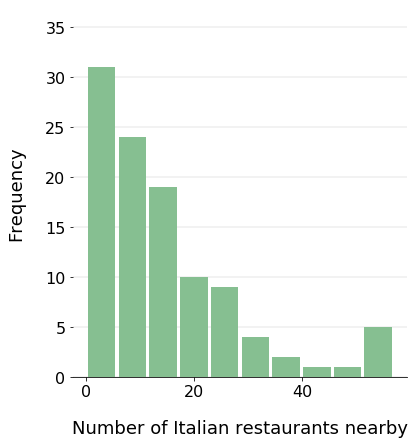

In [33]:
%matplotlib inline

ax = food_distrib.plot(kind='hist',x=2,bins=10,grid=False,\
               figsize=(6,6.75), layout=(1,2), sharex=False, color='#86bf91', zorder=2, rwidth=0.9, legend=None)



ax.set_xlabel('Number of Italian restaurants nearby',labelpad=20, size=18)
ax.set_ylabel('Frequency',labelpad=20, size=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Draw horizontal axis lines
vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, alpha=1, color='#eeeeee', zorder=1)

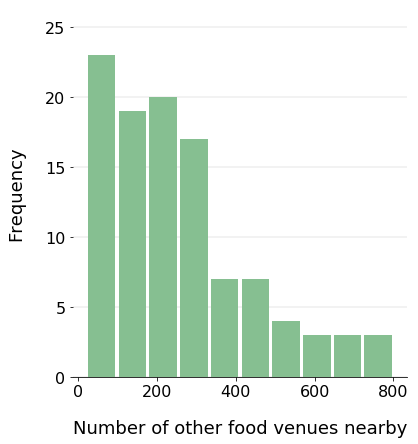

In [34]:
%matplotlib inline

ax = food_distrib.plot(kind='hist',x=1,bins=10,grid=False,\
               figsize=(6,6.75), layout=(1,2), sharex=False, color='#86bf91', zorder=2, rwidth=0.9, legend=None)



ax.set_xlabel('Number of other food venues nearby',labelpad=20, size=18)
ax.set_ylabel('Frequency',labelpad=20, size=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Draw horizontal axis lines
vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, alpha=1, color='#eeeeee', zorder=1)

Lets see some basic stats describing our data.

As we can see, that there are on average **14.7** Italian restaurants and **253.5** other food venues per area.

### Potential candidates <a name="potential_candidates"></a>

Our potential candidate areas will be chosen based on these criteria:
  * The number of Italian restaurants is equal or less than **6 (around first 25%)**.
  * The number of other food venues is equal or less than **214 (around first 50%)**.

In [36]:
candidates = food_distrib[food_distrib['Italian_restaurants'] <= 6].reset_index(drop=True)
candidates.tail()

,station_name,Italian_restaurants,Food_venues
29,West Kensington London Underground Station,3.0,83
30,Westminster London Underground Station,4.0,112
31,White City London Underground Station,2.0,123
32,Whitechapel London Underground and London Over...,2.0,132
33,Wood Lane London Underground Station,5.0,195


In [37]:
candidates = candidates[candidates['Food_venues'] <= 214].reset_index(drop=True)
candidates.tail()

,station_name,Italian_restaurants,Food_venues
26,West Kensington London Underground Station,3.0,83
27,Westminster London Underground Station,4.0,112
28,White City London Underground Station,2.0,123
29,Whitechapel London Underground and London Over...,2.0,132
30,Wood Lane London Underground Station,5.0,195


In [38]:
candidates = candidates.merge(metro_stations, left_on='station_name', right_on='name', how ='inner', sort=True)
candidates.drop('name', axis=1,inplace=True)
candidates.tail()

,station_name,Italian_restaurants,Food_venues,latitude,longitude
26,West Kensington London Underground Station,3.0,83,51.490719,-0.205978
27,Westminster London Underground Station,4.0,112,51.500922,-0.124802
28,White City London Underground Station,2.0,123,51.511630,-0.224127
29,Whitechapel London Underground and London Over...,2.0,132,51.519477,-0.061517
30,Wood Lane London Underground Station,5.0,195,51.510052,-0.223839


We have total of **32** potential candidate areas. Lets cluster them by their coordinates using [K-means clustering algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

[]

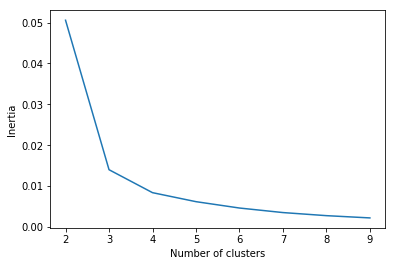

In [39]:
X = candidates[['latitude','longitude']]

val = []
#finding the best k
for k in range(2,10):
    clf = KMeans(n_clusters=k, random_state=0).fit(X)
    val.append(clf.inertia_)

plt.plot(range(2,10),val)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.plot()

Using the elbow method we choose the number of clusters to be equal to **k=3**.

In [40]:
k=3
clf = KMeans(n_clusters=k, random_state=0).fit(X)

candidates.insert(candidates.columns.shape[0], 'cluster',clf.labels_.tolist())
candidates.tail()

,station_name,Italian_restaurants,Food_venues,latitude,longitude,cluster
26,West Kensington London Underground Station,3.0,83,51.490719,-0.205978,1
27,Westminster London Underground Station,4.0,112,51.500922,-0.124802,0
28,White City London Underground Station,2.0,123,51.511630,-0.224127,1
29,Whitechapel London Underground and London Over...,2.0,132,51.519477,-0.061517,2
30,Wood Lane London Underground Station,5.0,195,51.510052,-0.223839,1


Lets visualize those 3 clusters we have identified.

In [41]:
map_candidates = folium.Map(location=[center_lat, center_lon], zoom_start=12,\
                  tiles='Stamen Toner', control_scale = True)

#select color for clusters
colors = sns.color_palette(n_colors=k)
colors = [ (int(color[0]*255),int(color[1]*255),int(color[2]*255)) for color in colors ]
colors = ['#%02x%02x%02x' % color for color in colors ]

# draw business districts for reference   
folium.GeoJson(districts, style_function=district_style, name='geojson').add_to(map_candidates)

# draw clusters
for idx, place in candidates.iterrows():
    
    folium.vector_layers.Circle(
        location=[place['latitude'], place['longitude']],
        popup=place['station_name'],
        fill_color = colors[place['cluster']],
        color = 'white',
        fill_opacity=0.7,
        radius = 500, #in meters
    ).add_to(map_candidates)
    
map_candidates

As we can see, pretty much all the potential areas are positioned on the outskirts
 of the business districts (the ones located inside the districts are already overpopulated by other restaurants).

### Choosing the final candidate <a name="final_candidate"></a>


As we can see from the map above areas within the blue cluster overlap with the business districts' areas the most and seem to be the most promising at first. There are only two candidates from the green cluster and none from the orange.

By looking at the blue cluster candidates more closely, one can notice that all of them are situated in the low business density area called 'Fringe' (based on [office sq. ft.](https://www.savills.co.uk/research_articles/229130/177600-0)).

On the other hand, the two candidates from the green cluster are situated on the edge of the densest part called 'Core'. So we will choose them as our most suitable candidates. They are areas around **Pimlico** and **Westminster** underground stations. 

And finally, from our two candidates we will chose the our final one. It is an easy task because one can quickly notice the type of buildings (Big Ben, UK Parlament) in the vicinity of the Westminster station and understand that the rental cost there is off the roof. So our final candidate is the area surrounding the Pimlico underground station.

**Pimlico and Millbank areas**

The Pimlico underground station is situated on the border of Pimlico and Millbank areas.

"**Pimlico** is an upscale residential area with quiet streets lined with stately 19th-century homes. Its many hotels, plus proximity to the Tate Britain gallery and stylish Chelsea, make it popular with travelers, while post-work crowds frequent the chic restaurants and old-school pubs by busy Vauxhall Bridge Road." (source: google.com venue description) 

"**Millbank** is an area of central London in the City of Westminster. Millbank is located by the River Thames, east of Pimlico and south of Westminster. Millbank is known as the location of major government offices, Burberry headquarters, the Millbank Tower and prominent art institutions such as Tate Britain and the Chelsea College of Art and Design." (source:[wikipedia.org](https://en.wikipedia.org/wiki/Millbank))

Lets gather all the data under station name 'Pimlico London Underground Station'.

In [42]:
pimlico_station = metro_stations[metro_stations['name'] == 'Pimlico London Underground Station']
pimlico_lat = pimlico_station['latitude'].values
pimlico_lon = pimlico_station['longitude'].values

pimlico_food = food_venues[food_venues['station_name'] == 'Pimlico London Underground Station'].reset_index(drop=True)
pimlico_italian =  only_italian[only_italian['station_name'] == 'Pimlico London Underground Station'].reset_index(drop=True)
pimlico_all_venues = pd.concat([pimlico_food,pimlico_italian]).reset_index(drop=True)
pimlico_food.tail()

,station_name,venue_name,venue_id,subcategory_name,subcategory_id,latitude,longitude
109,Pimlico London Underground Station,Wibke's Diner,4c7abb4f93ef236ab591b30f,Diner,4bf58dd8d48988d147941735,51.485707,-0.136974
110,Pimlico London Underground Station,Pomegranates,4ac518d8f964a52084a820e3,Restaurant,4bf58dd8d48988d1c4941735,51.486037,-0.136417
111,Pimlico London Underground Station,Cottons Rum Shack & Restaurant,5a0c4a7486f4cc18c3f2e87a,Caribbean Restaurant,4bf58dd8d48988d144941735,51.485975,-0.126533
112,Pimlico London Underground Station,Four Degree,5a2a9ce8b23dfa13acb392d3,Japanese Restaurant,4bf58dd8d48988d111941735,51.484983,-0.127620
113,Pimlico London Underground Station,Nelson's Ice Cream Van,4d8dd4cec479a35da49b3697,Food Truck,4bf58dd8d48988d1cb941735,51.485668,-0.127126


In [43]:
pimlico_italian.tail()

,station_name,venue_name,venue_id,subcategory_name,subcategory_id,latitude,longitude
1,Pimlico London Underground Station,Primo Piatti Pasta,5764430a498e8ccebe4df212,Italian Restaurant,4bf58dd8d48988d110941735,51.492557,-0.138955
2,Pimlico London Underground Station,The 8,4d8bae9ccdfbb60c5d875907,Italian Restaurant,4bf58dd8d48988d110941735,51.493324,-0.133528
3,Pimlico London Underground Station,cacio & pepe,55eae995498eb91ae6be7f73,Italian Restaurant,4bf58dd8d48988d110941735,51.491152,-0.139162
4,Pimlico London Underground Station,Gastronomica,4ad07fa5f964a5203bd820e3,Italian Restaurant,4bf58dd8d48988d110941735,51.491963,-0.138379
5,Pimlico London Underground Station,UNo.,4ac518dff964a520fda920e3,Italian Restaurant,4bf58dd8d48988d110941735,51.492193,-0.139986


In [44]:
pimlico_all_venues.tail(7)

,station_name,venue_name,venue_id,subcategory_name,subcategory_id,latitude,longitude
113,Pimlico London Underground Station,Nelson's Ice Cream Van,4d8dd4cec479a35da49b3697,Food Truck,4bf58dd8d48988d1cb941735,51.485668,-0.127126
114,Pimlico London Underground Station,Gustoso Ristorante & Enoteca,4fb521abe4b0fbb02db1667e,Italian Restaurant,4bf58dd8d48988d110941735,51.493587,-0.138619
115,Pimlico London Underground Station,Primo Piatti Pasta,5764430a498e8ccebe4df212,Italian Restaurant,4bf58dd8d48988d110941735,51.492557,-0.138955
116,Pimlico London Underground Station,The 8,4d8bae9ccdfbb60c5d875907,Italian Restaurant,4bf58dd8d48988d110941735,51.493324,-0.133528
117,Pimlico London Underground Station,cacio & pepe,55eae995498eb91ae6be7f73,Italian Restaurant,4bf58dd8d48988d110941735,51.491152,-0.139162
118,Pimlico London Underground Station,Gastronomica,4ad07fa5f964a5203bd820e3,Italian Restaurant,4bf58dd8d48988d110941735,51.491963,-0.138379
119,Pimlico London Underground Station,UNo.,4ac518dff964a520fda920e3,Italian Restaurant,4bf58dd8d48988d110941735,51.492193,-0.139986


Visualizing the food venue density in the area using folium HeatMap.

In [45]:
map_pimlico = folium.Map(location=[pimlico_lat, pimlico_lon], zoom_start=16, tiles='Stamen Toner', control_scale = True)

HeatMap(pimlico_all_venues[['latitude','longitude']].values, radius=60).add_to(map_pimlico)

folium.vector_layers.Circle(
    location=[pimlico_lat, pimlico_lon],
    popup='Pimlico London Underground Station',
    fill_color = 'white',
    color = 'white',
    fill_opacity=0.4,
    radius = 500, #in meters
).add_to(map_pimlico)

map_pimlico

Finding the places that are more than 200 meters from any other Italian restarant and 100 meters from any other food venue.

In [46]:
# get corner coords of the square
sw_sq, ne_sq = find_sw_ne(pimlico_lat, pimlico_lon,500)
# make a 20x20 grid
sw_grid, ne_grid, center_grid = make_grid(sw_sq,ne_sq,20) 
# save as DataFrame object
places_grid = pd.DataFrame({'no':np.arange(20*20),'center_lat':[ point[0] for point in center_grid],\
                           'center_lon':[ point[1] for point in center_grid]})
places_grid.tail()

,no,center_lat,center_lon
395,395,51.4848,-0.1295
396,396,51.4848,-0.1288
397,397,51.4848,-0.1281
398,398,51.4848,-0.1274
399,399,51.4848,-0.1266


In [47]:
#Looking for places that are farther than 100 meters from any other food venue
places = places_grid[['center_lat','center_lon']].values
foods = pimlico_food[['latitude','longitude']].values

dist = distance_2D(places,foods,data_type='lat_lon')
dist = dist < 100 # more than 50 meters
dist = dist.sum(axis=1)

idx = dist == 0
idx = idx.astype(int)

places_grid.insert(places_grid.columns.shape[0], 'far_from_food', idx.tolist())

In [48]:
#Looking for places that are farther than 200 meters from any other Italian restaurant
places = places_grid[['center_lat','center_lon']].values
italian = pimlico_italian[['latitude','longitude']].values

dist = distance_2D(places,italian,data_type='lat_lon')
dist = dist < 200 # more than 50 meters
dist = dist.sum(axis=1)

idx = dist == 0
idx = idx.astype(int)

places_grid.insert(places_grid.columns.shape[0], 'far_from_Italian', idx.tolist())

In [49]:
#flag the ones that are situated in the river Thames

# this approximate function was determined manually
delta = ( places_grid.iloc[199,1] - places_grid.iloc[389,1] )/(places_grid.iloc[199,2] - places_grid.iloc[389,2])

y= places_grid[['center_lat','center_lon']].values[:,0]
x= places_grid[['center_lat','center_lon']].values[:,1]

not_river = (x-places_grid.iloc[389,2])*delta < y-places_grid.iloc[389,1]
not_river = not_river.astype(int)

places_grid.insert(places_grid.columns.shape[0], 'not_river', not_river.tolist())

In [50]:
# determine places that match the requirements

tmp = places_grid.iloc[:,-3:].values
tmp = tmp.sum(axis=1)
tmp = tmp ==3
tmp = tmp.astype(int)
places_grid.insert(places_grid.columns.shape[0], 'good_place', tmp.tolist())

places_grid.tail()

,no,center_lat,center_lon,far_from_food,far_from_Italian,not_river,good_place
395,395,51.4848,-0.1295,1,1,0,0
396,396,51.4848,-0.1288,0,1,0,0
397,397,51.4848,-0.1281,0,1,0,0
398,398,51.4848,-0.1274,0,1,0,0
399,399,51.4848,-0.1266,0,1,0,0


Visuzalizig the potential places that meet all the requirements.

In [51]:
#Lets plot potential places

map_pimlico = folium.Map(location=[pimlico_lat, pimlico_lon], zoom_start=16,\
                         tiles='Stamen Toner', control_scale = True, \
                         width=1.920/1.08*550, height=550)

HeatMap(pimlico_food[['latitude','longitude']].values,\
                            radius=40).add_to(map_pimlico)

folium.vector_layers.Circle(
    location=[pimlico_lat, pimlico_lon],
    popup='Pimlico London Underground Station',
    fill_color = 'white',
    color = 'white',
    fill_opacity=0.4,
    radius = 500, #in meters
).add_to(map_pimlico)


for idx, place in places_grid.iterrows():
    if place['good_place']:
        folium.vector_layers.Circle(
            location=[place['center_lat'], place['center_lon']],
            popup=place['no'],
            fill=True,
            fill_color = 'blue',
            color = 'blue',
            fill_opacity=1,
            radius = 5, #in meters
        ).add_to(map_pimlico)
        
folium.Marker(
    location=[pimlico_lat, pimlico_lon],
    popup='Pimlico London Underground Station',
    icon=folium.Icon(color='red')
).add_to(map_pimlico)

map_pimlico

Clustering these places into zones using k-means clustering algorithm used before.

[]

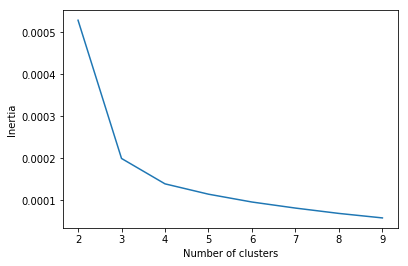

In [52]:
tmp = places_grid[places_grid['good_place'] == 1]
X = tmp[['center_lat','center_lon']].values

val = []
#finding the best k
for k in range(2,10):
    clf = KMeans(n_clusters=k, random_state=0).fit(X)
    val.append(clf.inertia_)

plt.plot(range(2,10),val)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.plot()

Using the elbow method the number of clusters equal to **k=4** is chosen.

In [53]:
k=4
clf = KMeans(n_clusters=k, random_state=0).fit(X)

clf.cluster_centers_

array([[51.48729091, -0.13234545],
       [51.48603913, -0.1392913 ],
       [51.49120625, -0.1298625 ],
       [51.48585294, -0.13459412]])

Visualizing the cluster centers and potential places around them.

In [54]:
map_pimlico = folium.Map(location=[pimlico_lat, pimlico_lon], zoom_start=16, tiles='Stamen Toner', control_scale = True)

folium.Marker(
    location=[pimlico_lat, pimlico_lon],
    popup='Pimlico London Underground Station',
    icon=folium.Icon(color='red')
).add_to(map_pimlico)
    
folium.vector_layers.Circle(
    location=[pimlico_lat, pimlico_lon],
    popup='Pimlico London Underground Station',
    fill_color = 'red',
    color = 'red',
    opacity=0.5,
    fill_opacity=0.2,
    radius = 500, #in meters
).add_to(map_pimlico)

for cluster in clf.cluster_centers_:
    #folium.vector_layers.Circle(
    #    location=[cluster[0], cluster[1]],
    #    color = 'orange',
    #    weight=3, 
    #    radius = 250, #in meters
    #).add_to(map_pimlico)
    
    folium.Marker(
        location=[cluster[0], cluster[1]],
        popup='lat: {0:.4f}, lon: {1:.4f}'.format(cluster[0],cluster[1]),
        icon=folium.Icon(color='blue')
    ).add_to(map_pimlico)

for idx, place in places_grid.iterrows():
    if place['good_place']:
        folium.vector_layers.Circle(
            location=[place['center_lat'], place['center_lon']],
            popup=place['no'],
            fill=True,
            fill_color = 'blue',
            color = 'blue',
            fill_opacity=1,
            radius = 5, #in meters
        ).add_to(map_pimlico)
        
for idx, place in places_grid.iterrows():
    if place['good_place']:
        folium.vector_layers.Circle(
            location=[place['center_lat'], place['center_lon']],
            popup=place['no'],
            color='#0000ff00',
            fill=True,
            fill_color = 'blue',
            fill_opacity=0.07,
            radius = 100, #in meters
        ).add_to(map_pimlico)
        
        

map_pimlico

Four cluster centers (blue markers) of the potential places (blue dots) for a new Italian restaurant within the range of 500 meters from the 'Pimlico underground station' (red marker).


### Reverse geocoding <a name="reverse_geocoding"></a>

Finaly, let's reverse geocode those area centers to get the approximate address names. For this task we will use the [LocationIQ API](https://locationiq.com/docs?). One must [register](https://locationiq.com/register) and receive a private token which is required to make any API calls. The free sign up allows up to **2 API calls per second**.

In [55]:
#define your token
locationiq_key = 'YOUR_PRIVATE_TOKEN'

In [57]:
#make API calls

#storing data
final_places = pd.DataFrame(columns=['address','latitude','longitude'])

url = "https://us1.locationiq.com/v1/reverse.php"

for place in clf.cluster_centers_:
    data = {
        'key': locationiq_key,
        'lat': str(place[0]),
        'lon': str(place[1]),
        'format': 'json'
    }

    response = requests.get(url, params=data).json()
    time.sleep(0.5)
    
    try:
        index= final_places.shape[0]
        address = response['address']['road'] +', '+response['address']['suburb']+', '+response['address']['city']
        final_places.loc[index] = [address,place[0],place[1]]
    except:
        pass

In [58]:
final_places.tail()

,address,latitude,longitude
0,"Balvaird Place, Millbank, London",51.487291,-0.132345
1,"Churchill Gardens Road, Pimlico, London",51.486039,-0.139291
2,"Erasmus Street, Millbank, London",51.491206,-0.129862
3,"St George's Square, Pimlico, London",51.485853,-0.134594


In [59]:
#calculate the distances to the metro station
places = final_places[['latitude','longitude']].values
station_coords = np.array([pimlico_lat,pimlico_lon]).T

dist = np.around( distance_2D(places,station_coords,data_type='lat_lon'), decimals=-1)


final_places.insert(final_places.columns.shape[0], 'dist_to_metro', [x[0] for x in dist.tolist()])
final_places.tail()

,address,latitude,longitude,dist_to_metro
0,"Balvaird Place, Millbank, London",51.487291,-0.132345,220.0
1,"Churchill Gardens Road, Pimlico, London",51.486039,-0.139291,530.0
2,"Erasmus Street, Millbank, London",51.491206,-0.129862,340.0
3,"St George's Square, Pimlico, London",51.485853,-0.134594,370.0


Addresses of those cluster centers will be a good starting point for exploring the neighborhoods to find the best possible location based on neighborhood specifics.

## Results and Discussion <a name="results"></a>

Our analysis shows that there are 106 underground metro stations in the rectangular area of 16x9 km representing major business districts in London. On average there are around 14 Italian restaurants and 253 other food venues within the radius of ~500 meters from the stations. We focused our attention on areas with the least number of food venues and closest to the centers of the business districts.

At first glance, the Hammersmith, West Kensington and Walham Green areas (also known as a part of the ‘Fringe’ area in the [savills research]( https://www.savills.co.uk/research_articles/229130/177600-0)) seem to be the best candidates but when the amount of office sq. ft. by area is taken into account, the two areas around Pimlico and Westminster underground stations are chosen as the most promising. The Pimlico area became the final candidate because of the likely hudge rental cost in the Westminister area.

The **Pimlico area** was analyzed further by creating a dense grid of location candidates (spaced ~50m apart) finding the places located at least 200m away from any other Italian restaurant and 100 meters from any other food venue.

Location candidates were clustered to create zones of interest containing a great number of location candidates. Addresses of these zones were found using reverse geocoding.

The result of this analysis is **4 zones** with a large number of potential new restaurant places. Of course, these zones are not optimal locations for a new restaurant. There may be very good reasons for a small number of food venues in these locations (e.x. locations pointing to places like a park, a river or a road where it is imposible to build or rent. Negative neighbourhood characteristics like pollution, noise and etc.) which would make them unsuitable for a new restaurant. Recommended zones should be considered only as a starting point for a more detailed 'street-level' analysis.

## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify areas close to a metro station with a low number of food venues (in particular Italian restaurants) to aid future investors in finding the potential location for a new Italian restaurant. By aiming at office workers as the future daily clients, only the metro stations situated in London's major business districts were taken into consideration.

By calculating food venue density distribution from Foursquare data we have first identified the most suitable candidate (Pimlico/Millbank area) and conducted the further analysis. An extensive collection of locations that satisfy some basic requirements regarding existing nearby restaurants was generated. These locations were clustered into 4 zones with their unique addresses.

A final decision on optimal restaurant location will be made by future investors based on specific characteristics of locations in every recommended zone, taking into consideration additional factors like proximity to a business center and major roads, rental prices, and other economic variables.